In [1]:
#| export
print_flag                    = True
check_memory_usage            = True
time_flag                     = True
window_size_percentage        = False
show_plots                    = True
reset_kernel                  = True
pre_configured_case           = False
case_id                       = 1
frequency_factor              = 5
frequency_factor_change_alias = True
check_parameters              = True
cuda_device                   = 1

# MPlot

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks is a tutorial of how to use the different methods defined in mplots.ipyn for the specific case of 'PulsusParadoxus'.

MPlots were introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)

It also integrates methods of Stumpy:
- [Tutorial: The Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Time-Series-with-Length-n-=-13)

Feel free of modifying the parameters and open issue in case of error!


-- > Note < -- 

For the example in this notebook, the instructions in [Introducing Mplots: Scaling Time Series Recurrence Plots to Massive Datasets](https://web.archive.org/web/20240125145941id_/https://assets.researchsquare.com/files/rs-3651179/v1_covered_ef5f7e93-ace3-4376-b6f6-3021b43d586c.pdf?c=1701243102) have been followed

## Notebook configuration
### Check parameters

In [2]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        " print_flag:", print_flag, "\n",
        "check_memory_usage", check_memory_usage, "\n",
        "time_flag:", time_flag, "\n",
        "window_size_percentage:" , window_size_percentage, "\n",
        "show_plots:",show_plots, "\n",
        "reset_kernel:",reset_kernel, "\n",
        "pre_configured_case:",pre_configured_case, "\n",
        "case_id:",case_id, "\n",
        "frequency_factor:", frequency_factor,  "\n",
        "frequency_factor_change_alias", frequency_factor_change_alias, "\n",
        "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
 print_flag: True 
 check_memory_usage True 
 time_flag: True 
 window_size_percentage: False 
 show_plots: True 
 reset_kernel: True 
 pre_configured_case: False 
 case_id: 1 
 frequency_factor: 5 
 frequency_factor_change_alias True 
 cuda_device 1 



### VsCode update patch
Initial notebook setup when using VSCode.

In [3]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

### Debugging variables

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.
- `show_plots`. If `True` all plots are shown within the execution of the notebook. Otherwise, none of them will be plotted.

In [4]:
#| export
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#print_flag             = True
#reset_kernel           = True
#check_memory_usage     = True
#time_flag              = True
#window_size_percentage = True
#show_plots             = True

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [5]:
#| export
import dvats.config as cfg_

In [6]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [7]:
#| export 
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#pre_configured_case = False
#case_id = None
#frequency_factor = 1
#frequency_factor_change_alias = True

## Main code
### Import libraries

In [8]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb


Octave is ready <oct2py.core.Oct2Py object at 0x7f61eb2c7640>

















### Initialize and Configurate Artifact

#### Initialize Weights and Biases

In [9]:
#| export
wandb_api = wandb.Api()

#### Setup CUDA

In [10]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 0
GPU | Used mem: 24
GPU | Memory Usage: [--------------------] 0%


### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/06_MPlots.ipynb'

In [11]:
# Ensure the correct execution path 
# Se puede hacer mejor con la ultima versión que hay en master del config.ipybn
# En esa versión se permite pasar paths por parámetro a las funciones de configuración
# Así no hay por qué forzar aquí path de ejecución
# Y se gana, además, bastante versatilidad

target_directory = os.path.expanduser("./work/nbs_pipeline")
print(target_directory)
%cd {target_directory}
#! ls

./work/nbs_pipeline
[Errno 2] No such file or directory: './work/nbs_pipeline'
/home/macu/work/nbs_pipeline


In [12]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        print_flag = print_flag, 
        both = print_flag,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

### Setup Weights & biases artiffact

In [13]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="_MPlot_PulsusParadoxus"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if print_flag: print("runname: "+runname)
if print_flag: cfg_.show_attrdict(config)

runname: _MPlot_PulsusParadoxus
alias: PulsusParadoxus-SP02
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (1, 100)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 900
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 100
wandb_group: None


In [14]:
job_type = 'MPlot'
job_type

'MPlot'

### Start W&B Run

In [15]:
#| export
if print_flag: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if print_flag: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


### Generating the MPlots

#### Get W&B train artifact
Build artifact selector
Botch to use artifacts offline

In [16]:
#| export
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if print_flag: print("---> W&B Train Artifact")

alias: PulsusParadoxus-SP02
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [1, 100]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 900
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 100
wandb_group: None
---> W&B Train Artifact


In [17]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [18]:
#| export
if print_flag: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(17521, 1)


<bound method NDFrame.head of                             0
1970-01-01 00:00:00 -1.193829
1970-01-01 00:00:01 -1.193829
1970-01-01 00:00:02 -1.193829
1970-01-01 00:00:03 -1.262998
1970-01-01 00:00:04 -1.286055
...                       ...
1970-01-01 04:51:56  0.601779
1970-01-01 04:51:57  0.475591
1970-01-01 04:51:58  0.475591
1970-01-01 04:51:59  0.297443
1970-01-01 04:52:00  0.119295

[17521 rows x 1 columns]>

df_train ~  (17521, 1)
window_sizes =  [1, 100]
wlen =  100


#### Time series data MatrixProfile

In [19]:
import dvats.mplots as mplots

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
import pyscamp as scamp
import dvats.memory as mem

In [21]:
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 0
GPU | Used mem: 24
GPU | Memory Usage: [--------------------] 0%


#### Initialize parameters

In [22]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = scamp.gpu_supported()
has_gpu_support

True

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

#### Checking the time serie

In [23]:
# Use step for selecting values in position k*step 
ts_step = 1
ts = df_train.iloc[:, 0].values[::ts_step] #For some reason. Trying to follow MPlot-figures-ref

In [24]:
pulsus_mp = mplots.MatrixProfile(
    data      = ts, 
    data_b    = ts, 
    self_join = False
) #Some error in naive, use it like this

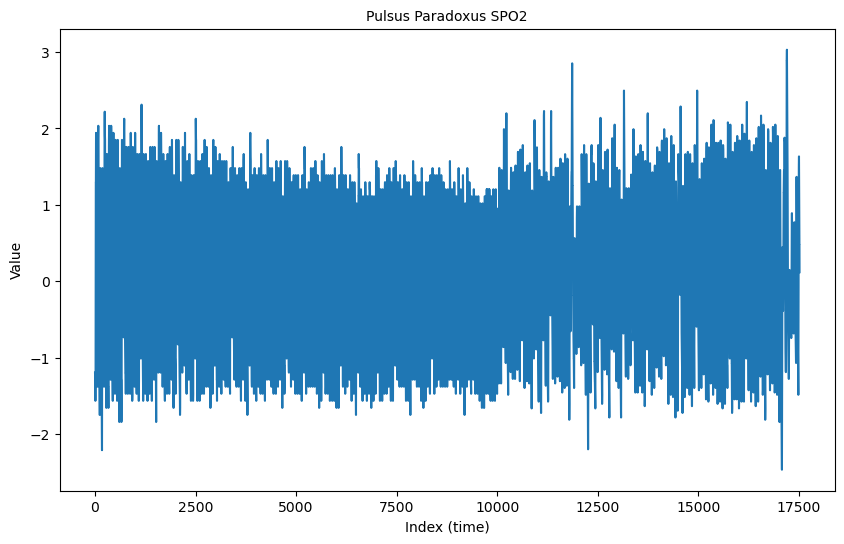

In [25]:
mplots.plot_with_dots(
    time_series = ts, 
    title = "Pulsus Paradoxus SPO2", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False
)

##### Chosing window length
Eamon et all use ''approximately 1 pulsus'': m = 50. 
Let's see what does Fourier transform detect

In [26]:
pulsus_mp.provide_lens(1)
pulsus_mp.dominant_lens

[27]

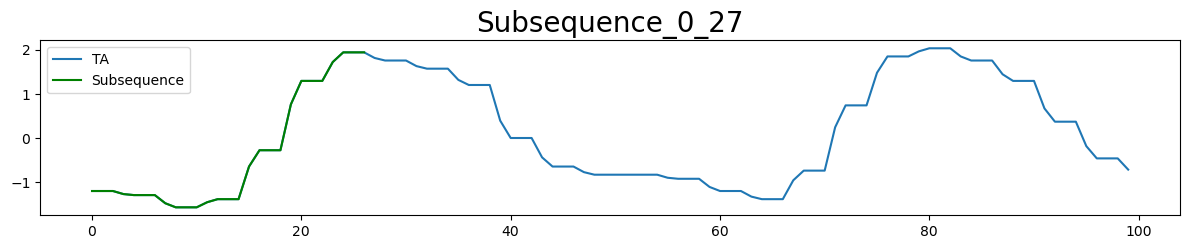

In [27]:
mplots.plot_subsequence(
    TA = ts[:100], 
    sequence_i = 0,
    subsequence_len = pulsus_mp.dominant_lens[0],
    dots = False,
    sequence_flag = False
)

And what happens if we use the double?

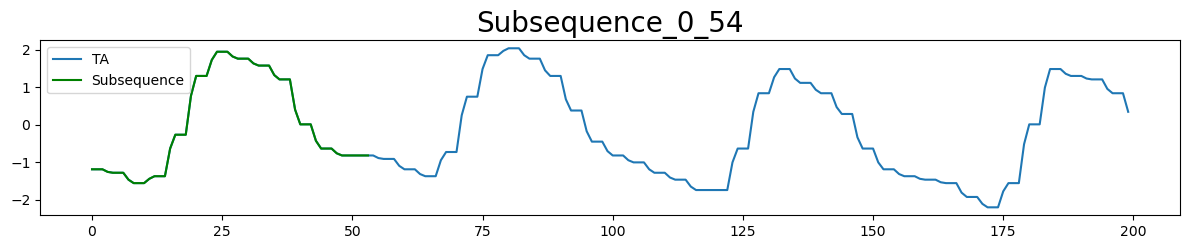

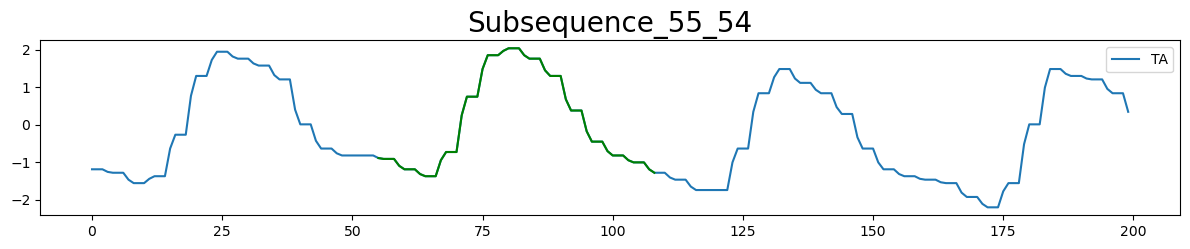

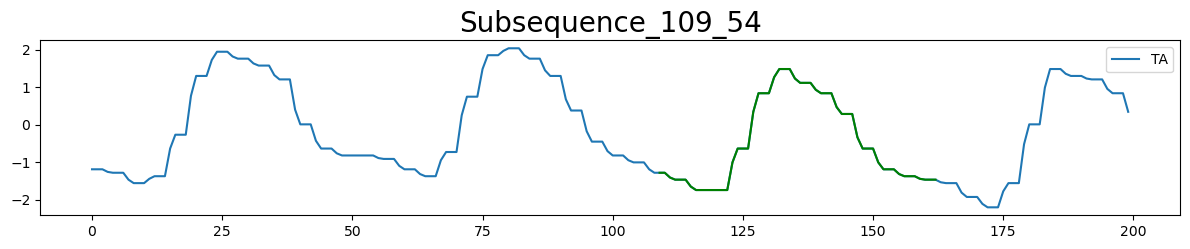

In [28]:
m = pulsus_mp.dominant_lens[0]*2
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False
)
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False
)
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = 2*m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False
)

This value seems to correspond to that idea of getting 'one pulsus' as subsequence length

In [29]:
pulsus_mp.compute(print_flag = True, d = euclidean_distance, method = 'stump')

--> matrix profile
--> Stump (CPU)
MP | Compute | Using stumpy.stump | normalize? False
matrix profile 14.229400634765625 seconds -->


array([0.655990928719318, 0.655990928719318, 0.6513146222967807, ...,
       0.39746789058627163, 0.40029955953466106, 0.3947554548118563],
      dtype=object)

In [30]:
len(pulsus_mp.index)

17495

Before: Pos 0 Add 0
Plot Interactive | After: Pos 0 Selected index 1350
Plot Interactive | Distances:  [0.655990928719318 0.655990928719318 0.6513146222967807 ...
 0.39746789058627163 0.40029955953466106 0.3947554548118563]
Plot Interactive | Window [0, 6350]


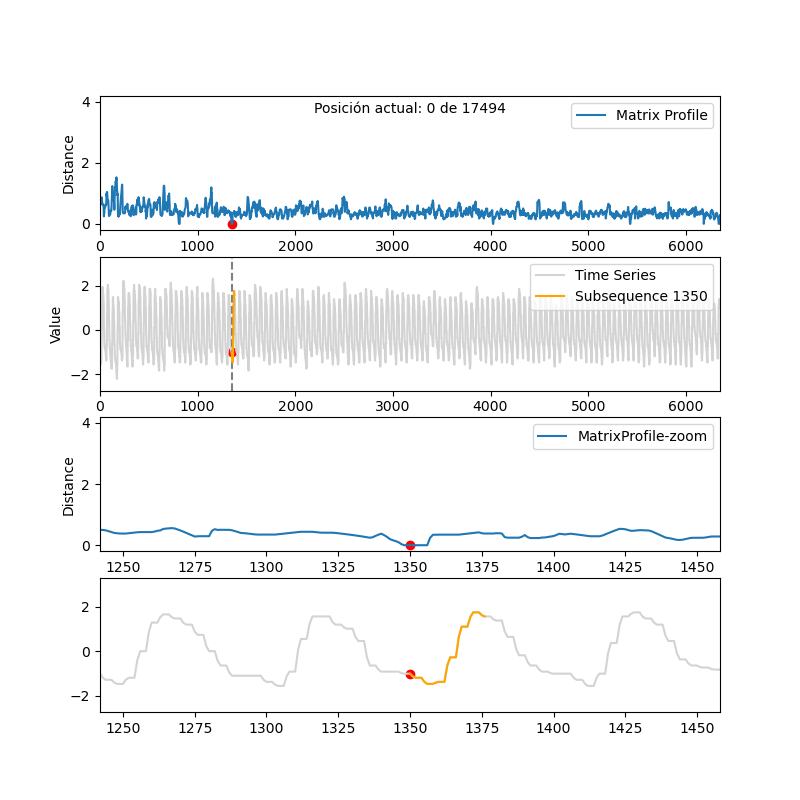

In [31]:
%matplotlib widget
pulsus_mp.plot_interactive(
    figsize = (8,8),
    print_flag =  True
)

#### Computando el MPlot

In [32]:
len(ts)

17521

In [33]:
pulsus_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [34]:
#| hide
print("MP_AB self_join", pulsus_MPlot.MP_AB.self_join)
print(f"DM_AB ~ {pulsus_MPlot.DM_AB.shape}")
print("MP_AB method:", pulsus_MPlot.MP_AB.method)
print("DM_AB method:", pulsus_MPlot.DM_AB.method)

MP_AB self_join True
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive


In [35]:
len(pulsus_MPlot.data_b)

17521

In [36]:
max_points = 5000
min_position = 0

In [74]:
pulsus_MPlot.compute(
    mp_method           = 'stump', 
    #mp_method           = "scamp_naive" --> Devuelve siempre 0 en el ejemplo de Pulsus Raxodus | why?
    #dm_method           = 'stump',
    dm_method           = 'scamp',
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    #allow_experimental  = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    #c_min               = 200*4,
    #c_max               = 200*6,
    #r_min               = 0, 
    #r_max               = 200,
    max_points          = max_points,
    #nlens              = 5,
    subsequence_len     = 50, #1 heartbeat
    #provide_len        = True,
    provide_len         = False,
    downsample_flag     = True,
    min_lag             = 8,
    print_depth         = 0,
    threads             = 1,
    gpus                = [1]
)

[ MPlot | Compute ] | -->  Downsample 
[ MPlot | Compute ] | ---> Downsample TA to 0 : 17521
[ MPlot | Compute ] | Downsample TA ~ 17522 ---> 
[ MPlot | Compute ] |  --> Downsample TB 
[ MPlot | Compute ] | Downsample TB_paa ~ 17522 ---> 
[ MPlot | Compute ] |Downsample -->
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 17522 ---> 
Ensure valid limits | Original [0, 17521]
Final [0, 17522]
Ensure valid limits | Original [0, 17521]
Final [0, 17522]
--> matrix profile
matrix profile 7.293929576873779 seconds -->


In [38]:
print(pulsus_MPlot.DM_AB.shape)
print(pulsus_MPlot.DM_AB.method)

(377, 177)
stump


In [75]:
print(len(ts))
print(len(pulsus_MPlot.MP_AB.distances))
print(pulsus_MPlot.MP_AB.distances)
print(pulsus_MPlot.DM_AB.distances)
print(pulsus_MPlot.mp_method)

17521
17472
[0.6038112046006783 0.6057843309142915 0.6261141646388806 ...
 0.23540418459801712 0.23821648810089657 0.243572163646782]
[[        inf         inf         inf ...  9.95826979  9.94860515
  10.19803903]
 [        inf         inf         inf ...  9.96892966  9.95930024
  10.19803903]
 [        inf         inf         inf ...  9.97964785  9.97006055
  10.19803903]
 ...
 [ 9.95826979  9.96892966  9.97964785 ...         inf         inf
          inf]
 [ 9.94860515  9.95930024  9.97006055 ...         inf         inf
          inf]
 [10.19803903 10.19803903 10.19803903 ...         inf         inf
          inf]]
stump


In [65]:
#| hide
print("MP_AB self_join", pulsus_MPlot.MP_AB.self_join)
print("DM_AB self_join", pulsus_MPlot.DM_AB.self_join)
print(f"DM_AB ~ {pulsus_MPlot.DM_AB.shape}")
print("MP_AB method:", pulsus_MPlot.MP_AB.method)
print("DM_AB method:", pulsus_MPlot.DM_AB.method)

MP_AB self_join False
DM_AB self_join False
DM_AB ~ (17473, 17473)
MP_AB method: stump
DM_AB method: stump


In [41]:
pulsus_MPlot.DM_AB.distances.shape

(377, 177)

Observando en [MPlots-pdf-Catalog](https://drive.google.com/file/d/1fjWUzVQf-8XmS5epDa_ulm4-bDX51Vxv/view) hay un motif de longitud 187 en aproximadamente la posicion:

In [42]:
fraction = 205000/4
print(fraction)
approximated_position_in_eamonn_plot = fraction + (2 * fraction / 3)
print(f"Approximated position in eammon's plot {approximated_position_in_eamonn_plot}")

51250.0
Approximated position in eammon's plot 85416.66666666666


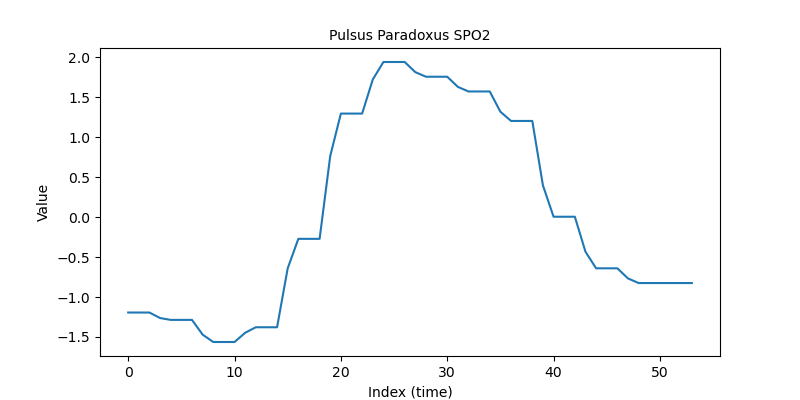

In [43]:
#plot_numpy_array(ts[81000:102500], figsize = (30,5))
#plot_numpy_array(ts[data_MPlot.x_min:data_MPlot.x_max], figsize = (15,5))
#plot_numpy_array(ts, figsize = (10,5))
plt.close('all')
mplots.plot_with_dots(
    time_series   = ts[0:27*2], 
    title         = "Pulsus Paradoxus SPO2", 
    sequence_flag = False, 
    fontsize      = 10,
    dots          = False,
    figsize       = (8,4)
)

Max points: 3000


Before: Pos 0 Add 0
Plot Interactive | After: Pos 0 Selected index 15177
Plot Interactive | Distances:  [0.6038112046006783 0.6057843309142915 0.6261141646388806 ...
 0.23540418459801712 0.23821648810089657 0.243572163646782]
Plot Interactive | Window [13677, 16677]


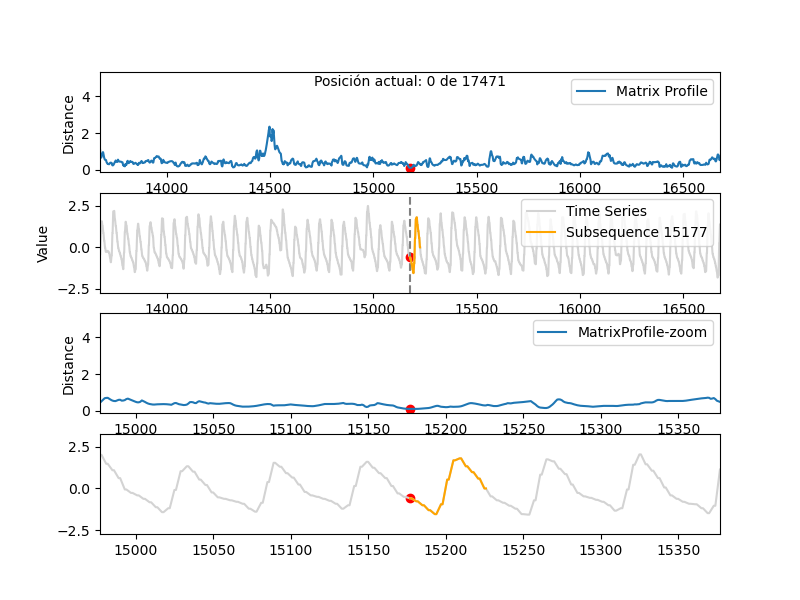

In [44]:
%matplotlib widget
#data_MPlot.MP_AB.max_points = 100+data_MPlot.subsequence_len
max_points = 3000
print(f"Max points: {max_points}")
pulsus_MPlot.MP_AB.max_points = max_points
pulsus_MPlot.MP_AB.plot_interactive(print_flag = True, figsize=(8,6))

In [77]:
threshold_scamp = 10
threshold_stump = 7.5
threshold = threshold_stump if pulsus_MPlot.DM_AB.method == 'stump' else threshold_scamp

In [ ]:
print(threshold)
pulsus_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    print_flag  = False,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = threshold,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'Variable 0: MPlot | ' + pulsus_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = False
)

10


In [47]:
pulsus_MPlot.plot_as_matlab

True

In [68]:
c_min = int(np.floor(10000/ts_step))
c_max = min(int(np.ceil(12000/ts_step))+1, pulsus_MPlot.DM_AB.distances.shape[1])
r_min = max(0,int(np.floor(0/ts_step)))
r_max = min(int(np.ceil(2000/ts_step))+1, pulsus_MPlot.DM_AB.distances.shape[0])
print(f"R({r_min}, {r_max}) C({c_min}, {c_max}) ")

R(0, 2001) C(10000, 12001) 


Threshold:  7.5
R(0, 2001) C(10000, 12001) 


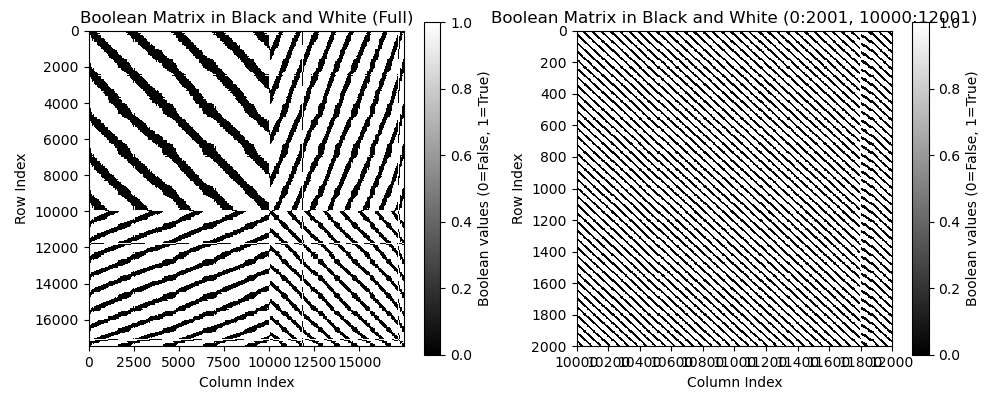

In [69]:
print("Threshold: ", threshold)
threshold = 7.5
data = mplots.threshold_interval(pulsus_MPlot.DM_AB.distances, threshold,np.inf,True, True, gray_color = False)

# Crear una figura con dos subplots uno al lado del otro
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Mostrar la matriz completa
axes[0].imshow(data, cmap='gray', interpolation='none')
axes[0].set_title('Boolean Matrix in Black and White (Full)')
axes[0].set_xlabel('Column Index')
axes[0].set_ylabel('Row Index')
plt.colorbar(
    axes[0].imshow(
        data, 
        cmap='gray', 
        interpolation='none'
    ), 
    ax=axes[0], 
    label='Boolean values (0=False, 1=True)'
)

# Mostrar el trozo de la matriz
axes[1].imshow(data[r_min:r_max, c_min:c_max], cmap='gray', interpolation='none')
axes[1].set_title(f'Boolean Matrix in Black and White ({r_min}:{r_max}, {c_min}:{c_max})')
axes[1].set_xlabel('Column Index')
axes[1].set_ylabel('Row Index')

step = 200

print(f"R({r_min}, {r_max}) C({c_min}, {c_max}) ")

xticks = np.arange(c_min, c_max, step)
yticks = np.arange(r_min, r_max, step)

axes[1].set_xticks(xticks-c_min)
axes[1].set_yticks(yticks-r_min)

axes[1].set_xticklabels(xticks)
axes[1].set_yticklabels(yticks)

plt.colorbar(axes[1].imshow(data[r_min:r_max, c_min:c_max], cmap='gray', interpolation='none'), ax=axes[1], label='Boolean values (0=False, 1=True)')

# Ajustar el layout
plt.tight_layout()
plt.show()


In [50]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

c: (10000, 177), r: (0, 377)


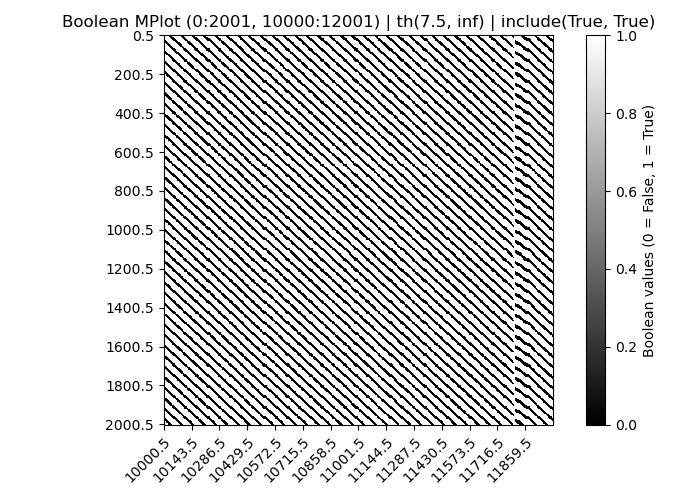

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [70]:
#print("Threshold: ", threshold)
pulsus_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    print_flag   = False,
    less_labels  = True,
    r_min        = r_min,
    r_max        = r_max,
    c_min        = c_min,
    c_max        = c_max,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = False,
    plot_mp_flag = False,
    print_depth  = 2
)

Threshold:  7.5
MPlot | Plot DM | DM_AB[0:2001, 10000:12001] ~ (0, 17473)
Plotting as MATLAB


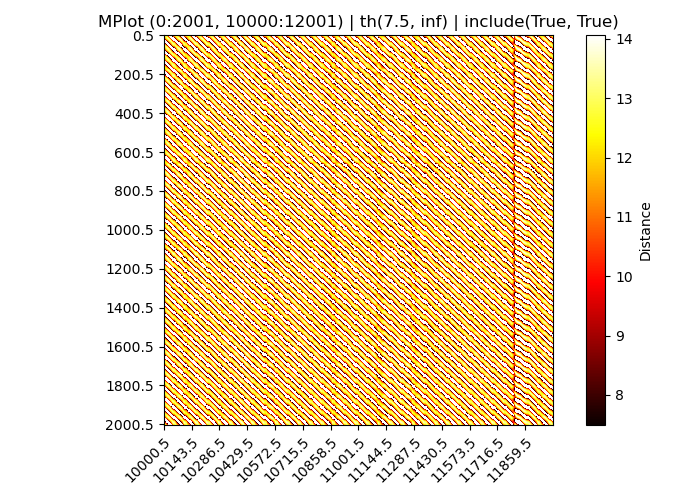

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [71]:
print("Threshold: ", threshold)
pulsus_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    print_flag   = True,
    less_labels  = True,
    r_min        = r_min,
    r_max        = r_max,
    c_min        = c_min,
    c_max        = c_max,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = True,
    plot_mp_flag = False
)

In [72]:
run.finish

<bound method Run.finish of <wandb.sdk.wandb_run.Run object at 0x7f61eb12b4c0>>